In [104]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
import requests
import os.path as osp
import pickle
import random
import numpy as np
from pathlib import Path
import sys
import os
import os.path as osp
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [103]:
model_path = "test_model"
Path(model_path).mkdir(parents=True, exist_ok=True)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def get_label(file):
    return " ".join(file.split("\\")[1].split(".")[0].split("_"))

### 1 load test data set

In [4]:
base = "test_images"
image_list = []
for image in os.listdir(base):
    image_list.append(osp.join(base, image))
    
text_list = [get_label(file) for file in image_list]

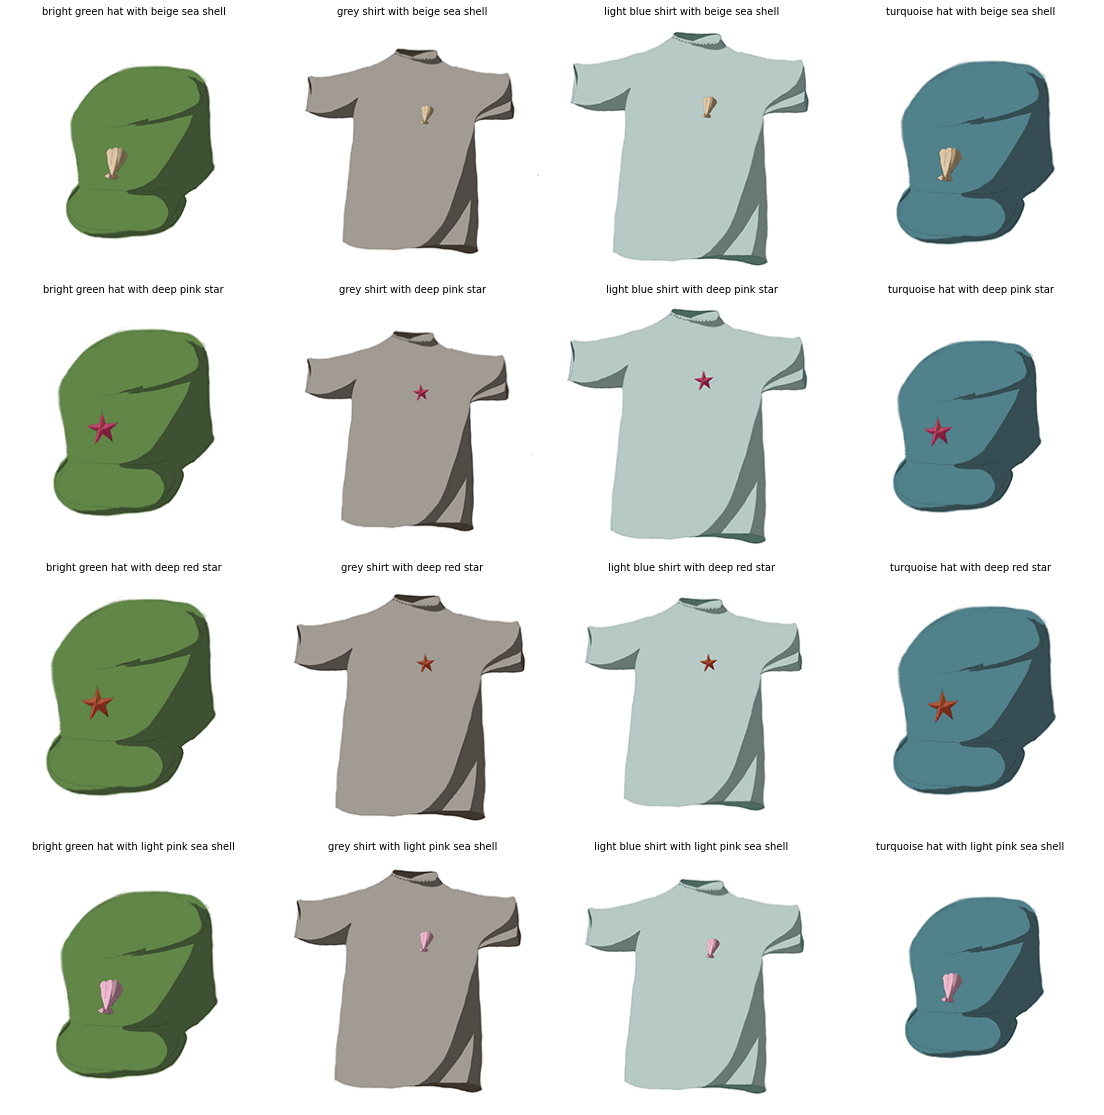

In [95]:
fig, ax = plt.subplots(4, 4)

fig.set_figheight(20)
fig.set_figwidth(20)

for i, image in enumerate(image_list):
    k = i % 4
    m = i // 4
    img = mpimg.imread(image)
    ax[k][m].imshow(img)
    ax[k][m].axis('off')
    ax[k][m].set_title(get_label(image), fontsize=10)
    
plt.subplots_adjust(wspace=0, hspace=0.1)

### 2 preprocess test data set

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [28]:
eimage_list = []
etext_list = []
for image, text in zip(image_list, text_list):
    
    image = preprocess(Image.open(image)).unsqueeze(0)
    text = clip.tokenize(text)

    eimage_list.append(image)
    etext_list.append(text)
    
df = pd.DataFrame(data={
    "encoded_image": eimage_list,
    "encoded_text": etext_list
})

In [48]:
# df["encoded_text"].values

In [32]:
train_data,test_data = train_test_split(df)

In [72]:
len(train_data)

12

In [ ]:
len(test_data)

4

### 3 test train and evaluate model

In [118]:
def calc_loss(data, criterion, device):
    encoded_images = torch.cat(list(data["encoded_image"].values)).to(device)
    encoded_texts = torch.cat(list(data["encoded_text"].values)).to(device)

    logits_per_image, logits_per_text = model(encoded_images, encoded_texts)

    # during training # images == # texts, so calc only once
    n_classes = logits_per_image.shape[0]
    device = device
    labels = torch.arange(n_classes, device=device, dtype=torch.long)
    
    loss_image = criterion(logits_per_image, labels)
    loss_text = criterion(logits_per_text, labels)
    curr_loss = (loss_image + loss_text)/2
    
    return curr_loss


def train(model, train_data, criterion, device, optimizer):
    
    model.train()
    total_loss = 0
    total_count = 0
    
    # print(f"training...")

    optimizer.zero_grad()
    curr_loss = calc_loss(train_data, criterion, device)

    curr_loss.backward()
    optimizer.step()

    total_loss = curr_loss.item()
    total_count = len(train_data)

    print(f"training average loss: {total_loss/total_count}")
            
            
def evaluate(model, test_data, criterion, device):
    
    model.eval()
    total_loss = 0
    total_count = 0
    
    with torch.no_grad():
        # print(f"evaluating...")

        curr_loss = calc_loss(test_data, criterion, device)

        total_loss = curr_loss.item()
        total_count = len(test_data)

        print(f"evaluation average loss: {total_loss/total_count}")
    
    
def run_epoch(
    model,
    train_data,
    test_data,
    criterion,
    device,
    optimizer,
    n_epoch,
    seed=1234,
):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    for n in range(n_epoch):
        print(f"training epoch: {n}")
        train(model, train_data, criterion, device, optimizer)
        evaluate(model, test_data, criterion, device)

In [119]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.00005
betas = (0.9, 0.98)
eps = 1e-6
weight_decay = 0.2
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    betas=betas, 
    eps=eps, 
    weight_decay=weight_decay
)
n_epoch = 20

run_epoch(model, train_data, test_data, criterion, device, optimizer, n_epoch)
torch.save(
    model.state_dict(),
    str(osp.join(model_path, 'test_model.pt'))
)

training epoch: 0
training average loss: 0.06914730866750081
evaluation average loss: 0.5312100648880005
training epoch: 1
training average loss: 0.5840055545171102
evaluation average loss: 0.41316744685173035
training epoch: 2
training average loss: 0.2677916884422302
evaluation average loss: 0.23105072975158691
training epoch: 3
training average loss: 0.1624393860499064
evaluation average loss: 0.7620494961738586
training epoch: 4
training average loss: 0.2629661560058594
evaluation average loss: 0.13143375515937805
training epoch: 5
training average loss: 0.13177770376205444
evaluation average loss: 0.06945284456014633
training epoch: 6
training average loss: 0.11106034119923909
evaluation average loss: 0.029364950954914093
training epoch: 7
training average loss: 0.09576476613680522
evaluation average loss: 0.013791159726679325
training epoch: 8
training average loss: 0.09032931923866272
evaluation average loss: 0.011241402477025986
training epoch: 9
training average loss: 0.085757

### 4 test the fine tuned model

In [122]:
def find_text_match(image, text_list):
    # given an image and a list of possible text matchs, find the best match
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    text = clip.tokenize(text_list).to(device)

    with torch.no_grad():

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    res = dict(zip(text_list, probs[0] * 100))
    return res

In [123]:
idx = 10
res = find_text_match(image_list[idx], text_list)
print(image_list[idx])
res

test_images\light_blue_shirt_with_deep_red_star.png


{'bright green hat with beige sea shell': 4.9922432e-06,
 'bright green hat with deep pink star': 0.00036575695,
 'bright green hat with deep red star': 0.0016393058,
 'bright green hat with light pink sea shell': 0.00096750783,
 'grey shirt with beige sea shell': 2.4273737e-05,
 'grey shirt with deep pink star': 0.032101024,
 'grey shirt with deep red star': 0.37577233,
 'grey shirt with light pink sea shell': 0.25709063,
 'light blue shirt with beige sea shell': 0.0043493016,
 'light blue shirt with deep pink star': 5.003631,
 'light blue shirt with deep red star': 69.52385,
 'light blue shirt with light pink sea shell': 24.70863,
 'turquoise hat with beige sea shell': 7.323057e-06,
 'turquoise hat with deep pink star': 0.008904726,
 'turquoise hat with deep red star': 0.04919583,
 'turquoise hat with light pink sea shell': 0.033445776}